In [74]:
#Import Necessary Libraries
import pandas as pd
import numpy as np
import nltk
import textstat
#nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from nltk import pos_tag
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from textstat.textstat import textstat
from matplotlib.table import Table
from scipy.stats import multivariate_normal, invwishart
from abc import ABC, abstractmethod
%matplotlib inline

In [75]:
df = pd.read_csv('raw_dataset - Sheet3.csv')

In [76]:
df

,index,title,author,text,publisher,datepublished,link
0,1,The Marcoses' three-body problem,John Nery,The success of the Marcos-Duterte electoral al...,Rappler,4/1/2024,https://www.rappler.com/voices/thought-leaders...
1,2,State of the opposition: Worth dying for,John Nery,The war on Ninoy Aquino’s legacy is a fight th...,Rappler,8/30/2022,https://www.rappler.com/voices/thought-leaders...
2,3,Elon Musk and magical thinking,John Nery,One of many lessons from the ongoing Twitter f...,Rappler,11/25/2022,https://www.rappler.com/voices/thought-leaders...
3,4,So what's wrong with Marcos's F1 party?,John Nery,Of course we all need to be particular about t...,Rappler,10/06/2022,https://www.rappler.com/voices/thought-leaders...
4,5,Patricia Evangelista and writing the war,John Nery,"In 'Some People Need Killing,' the acclaimed j...",Rappler,10/18/2023,https://www.rappler.com/life-and-style/literat...
5,6,What do we do about Alice Guo,John Nery,The answers she gave in two Senate hearings we...,Rappler,05/29/2024,https://www.rappler.com/voices/thought-leaders...
6,7,The media is not the press,John Nery,Confusing one with the other allows disinforma...,Rappler,04/13/2024,https://www.rappler.com/voices/thought-leaders...
7,8,The paradoxical pope,John Nery,The complicated but lasting legacy of Benedict...,Rappler,01/04/2023,https://www.rappler.com/voices/thought-leaders...
8,9,What's next for VP Sara: Go Macapagal or go Ar...,John Nery,Now that she has passed the point of no return...,Rappler,05/21/2024,https://www.rappler.com/voices/thought-leaders...
9,10,Time to negotiate peace again with the CPP-NPA,John Nery,The communist insurgency is at its weakest. Co...,Rappler,05/11/2024,https://www.rappler.com/voices/thought-leaders...


In [77]:
def preprocess_text(text):
    # Convert to lowercase
    return text.lower()

# Helper function to calculate complex sentence ratio
def count_clauses(sentence):
    # A simple approximation using commas, semicolons, and conjunctions
    return sentence.count(',') + sentence.count(';') + sentence.lower().count('and') + sentence.lower().count('but')

# Feature extraction function
def extract_features(text):
    # Tokenize words, sentences, and paragraphs
    words = word_tokenize(text)
    sentences = sent_tokenize(text)
    paragraphs = text.split('\n\n')  # Assuming paragraphs are separated by double newlines

    # Basic metrics
    word_count = len([word for word in words if word.isalpha()])
    avg_word_length = np.mean([len(word) for word in words if word.isalpha()]) if word_count > 0 else 0
    avg_sentence_length = word_count / len(sentences) if len(sentences) > 0 else 0
    paragraph_count = len(paragraphs)
    avg_paragraph_length = word_count / paragraph_count if paragraph_count > 0 else 0

    # Punctuation metrics
    punctuation_count = sum(1 for char in text if char in ['.', ',', ':', ';', '?', '!', '-', '\'', '\"'])
    punctuation_ratio = punctuation_count / word_count if word_count > 0 else 0
    avg_punctuation_per_sentence = punctuation_count / len(sentences) if len(sentences) > 0 else 0

    # Linguistic diversity features
    vocab_size = len(set([word for word in words if word.isalpha()]))
    vocab_ratio = vocab_size / word_count if word_count > 0 else 0

    # Readability metrics
    flesch_reading_ease = textstat.flesch_reading_ease(text)
    gunning_fog = textstat.gunning_fog(text)
    smog_index = textstat.smog_index(text)
    cl_index = textstat.coleman_liau_index(text)

    # Sentence complexity metrics
    total_clauses = sum(count_clauses(sentence) for sentence in sentences)
    avg_clauses_per_sentence = total_clauses / len(sentences) if len(sentences) > 0 else 0
    complex_sentence_ratio = sum(1 for sentence in sentences if count_clauses(sentence) > 1) / len(sentences) if len(sentences) > 0 else 0

    # Lexical density
    pos_tags = pos_tag(words)
    content_words = [word for word, pos in pos_tags if pos.startswith(('NN', 'VB', 'JJ', 'RB'))]
    lexical_density = len(content_words) / word_count if word_count > 0 else 0

    return {
        'word_count': word_count,
        'sentence_count': len(sentences),
        'paragraph_count': paragraph_count,
        'avg_paragraph_length': avg_paragraph_length,
        'avg_word_length': avg_word_length,
        'avg_sentence_length': avg_sentence_length,
        'punctuation_count': punctuation_count,
        'punctuation_ratio': punctuation_ratio,
        'avg_punctuation_per_sentence': avg_punctuation_per_sentence,
        'vocab_size': vocab_size,
        'vocab_ratio': vocab_ratio,
        'flesch_reading_ease': flesch_reading_ease,
        'gunning_fog': gunning_fog,
        'smog_index': smog_index,
        'coleman_liau_index': cl_index,
        'avg_clauses_per_sentence': avg_clauses_per_sentence,
        'complex_sentence_ratio': complex_sentence_ratio,
        'lexical_density': lexical_density
    }

In [78]:
# Apply preprocessing and feature extraction to each text sample
df['preprocessed_text'] = df['text'].apply(preprocess_text)
df_features = df.apply(lambda row: extract_features(row['preprocessed_text']), axis=1).apply(pd.Series)
df = pd.concat([df, df_features], axis=1)

In [79]:
# Model training
X = df[['word_count', 'avg_word_length', 'avg_sentence_length', 'paragraph_count', 'avg_paragraph_length',
        'punctuation_ratio', 'avg_punctuation_per_sentence', 'vocab_size', 'vocab_ratio', 
        'flesch_reading_ease', 'gunning_fog', 'smog_index', 'coleman_liau_index',
        'avg_clauses_per_sentence', 'complex_sentence_ratio', 'lexical_density']]
y = df['author']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [80]:
def classify_new_text(new_text, model):
    # Preprocess the text and extract features
    preprocessed_text = preprocess_text(new_text)
    new_features = extract_features(preprocessed_text)
    new_features_df = pd.DataFrame([new_features])

    # Reindex using the cleaned X_train's columns
    new_features_df = new_features_df.reindex(columns=X_train.columns)

    # Handle any NaN values
    new_features_df = new_features_df.fillna(0)

    # Predict the author
    predicted_author = model.predict(new_features_df)
    return predicted_author[0]

In [81]:
# #new_text = "Even the most talented scriptwriters of the best Netflix series would probably find their jaws dropping in bewilderment and shock with all the plot twists in this seemingly never-ending Alice in Wonderland fairytale, Manila edition. It’s as bizarre as it can get. Here is Alice, back in Manila via a private jet after being caught by Indonesian authorities, still making a mockery of our institutions, our law-enforcement agencies, our Immigration policies and our Senate. Alice told a Senate panel on Monday that they left the country via a yacht which they boarded right in the City of Manila. However, she isn’t very sure which part of the Manila harbor – the busiest port in the country – they departed from. This is the latest script that’s being fed to everyone following this edge-of-your seat drama. It’s different from the first version which said that they left on a small boat from Pangasinan. Either she is lying to keep the narrative confusing or she’s really hopelessly and impossibly bizarre. The truth is, our senators may never be able to fully unmask Alice Guo or to really squeeze the whole truth from her. However, it’s not a futile investigation. It has, in fact, led to policy changes, including a ban on Philippine offshore gaming operations. But more importantly, this whole Alice in Wonderland saga is pointing to a very disturbing reality in the Philippines, which our authorities must immediately address. I’m talking about the existence of syndicates issuing fake birth certificates and fake passports or illegally issuing such legitimate documents. This is appalling, disturbing and most of all a treachery to our people and our country. This is a serious security concern and each and every Filipino who is involved in this crime is a traitor of the worst kind and must be dealt with as such. In ancient Greece, high treason was punished severely, including the loss of citizenship for oneself and family. Here in our country today, these traitors among us must be brought to justice. Imagine what could happen if our official documents are forged, bootlegged or sold illegally. Never mind the fact that the most ordinary of ordinary Filipinos need to spend hours if not days just to get their official documents – whether it’s a birth certificate, a passport or a driver’s license. Years ago, for example, I remember a domestic helper who missed her flight to Malaysia because she could not get a passport. Why? Because she needed two government IDs but she only had one, a Philippine Postal ID. Her employer had to enroll her in a driving school so she could get a driver’s license, which would then serve as her second ID so she could get a passport. But by then it was too late. But as I said, never mind that. Filipinos are used to incompetence anyway. What is more disturbing, however, is the impact of this on our security. If our passports and birth certificates can easily be acquired illegally for a song, the same goes for land registration titles and other crucial documents. We may wake up one day and a big portion of our country is already owned by foreigners who managed to produce fake IDs or fake land titles in acquiring properties. We must also guard our borders because as Alice Guo has clearly shown, it’s so easy to escape the country, especially with our porous borders unguarded. Security is made worse by the fact that border patrols and immigration authorities just conveniently look the other way to help fugitives escape the law. What is our society, really, but a tale of dark comedy in continuous motion, if not an edge-of-your seat Netflix series playing in a loop over and over. If this Alice in Wonderland saga would help solve one thing, let it be this problem of fake documents and ID mills. For instance, there is supposedly a fake birth certificate factory in Davao, catering to mostly Chinese nationals. Such treacherous activities are alarming and President Marcos should not allow this to continue right under his nose. Unless we bring these perpetrators to justice and quash the syndicates they work for, we may remain a nation of fools and traitors. Our country is a stark and sad reminder of how greed, selfishness and betrayal have, time and time again, sold this nation’s soul. On the lighter side, “Fernando Zóbel: The Future of the Past” has arrived in Asia, premiering at the Ayala Museum after a four-month run at the Museo Nacional del Prado in Madrid. The exhibit will feature more than 200 works by the painter Zóbel, including sketchbooks that have never been seen by the public. I missed the vernissage but I was told that the exhibit will run until 2025, in celebration of Ayala Corp.’s 190th founding anniversary, the 100th birth anniversary of Zobel and the 50th anniversary of Ayala Museum."
# new_text = """Disrespecting the law is no less than an act of insolence, and in the “Law Insider” formulation, that is arrogant, presumptuous, impudent, or in fact even insulting. It could even be at once rude because it is no less than the Philippine law that is being crushed. 

# What Alice Guo did was a shameless disregard of the law, call it contempt of the law. If true, being non-Filipino made it worse, many times over. Of course, no less disrespectful of the law is how Apollo Quiboloy broke it by refusing to surrender to the authorities, until recently, despite the arrest warrant served to him in his own kingdom. 

# Unfortunately, disrespect of the law, rather than the rule of law, has a long history in the Philippines.

# The American expatriate businessman Harry Stonehill broke the law when he bribed high-level government officials in the early 1960s. His case also dragged at least three former presidents in order to protect his $50 million business in tobacco and various commercial crops, among others. Then Justice Secretary Jose W. Diokno caused the raid of the offices of 42 of Stonehill’s business establishments in 1962 and the arrest of Stonehill and some of his associates. 

# Based on what was described as six army trucks worth of incriminating evidence, Stonehill was accused of tax evasion, economic sabotage, and various other charges that could have been established by his Blue Book which mysteriously went missing. It contained the names of Filipino politicians and government officials who were alleged to have received bribe money from the American businessman. Before the case could be tried in court, Stonehill was subsequently deported by Malacañang.

# Alice Guo treated Philippine law like rag when all evidence points to her faking her birth circumstances to gain entry into the Philippines and become a Filipino citizen. If she is indeed non-Filipino and therefore disqualified, she violated our electoral law when she ran and took her oath of office as mayor of Bamban, Tarlac. This gains credence in the face of Guo’s fingerprints being a perfect match with a Chinese national, Guo Hua Ping. Guo could not explain how she was able to construct the multibillion building complex of POGO business in Tarlac. It was impossible because her tax returns and SALN could only support a modest lifestyle.

# As Reuters reported, even as Philippine authorities had filed several counts of money laundering, Guo continues to insist “she is natural-born Philippine citizen facing ‘malicious accusations,’ and had no knowledge of criminality.” This is strange because she could not even remember her roots, even her playmates while growing up.

# For weeks before she escaped from the Philippines to Malaysia, Singapore and Indonesia, our elected senators could not get through her. It was a blank wall for them when Guo would always retort that she grew up in a farm, her only close friends were the farmhands in their piggery, or when confronted by documentary evidence of her true nationality, that she could not remember anymore. 

# The bigger picture is the undeniable involvement of those in authority. 

# She could not have entered the Philippines without the complicity of our immigration authorities. She could not have produced her Filipino birth certificate without the knowledge of the civil registrar and the statistics authorities. She could not have run for public office if our election authorities conducted a simple due diligence. She could not have sustained her POGO and alleged illegal activities if law enforcers did not turn a blind eye. She could not have escaped from the Philippines in July without official intervention. 

# It's a sad commentary that even notarization of public documents could be dragged into this scandal. As Rappler reported, a lawyer “committed lapses when he notarized the counter-affidavit of suspended Bamban Mayor Alice Guo in relation to a DOJ human trafficking complaint on Aug. 14.” By that time, Guo was already out of the country. 

# When she was finally arrested by Indonesian Interpol in Tangerang, it was disclosed that a Singaporean national helped Guo book four hotel rooms in Batam island. And to the surprise of many, no less than Interior Secretary Benhur Abalos and PNP Chief PGen. Rommel Marbil who served the Senate arrest warrant to Guo. She was brought back to Manila in yes, a private plane. 

# There was little progress during the Senate hearing, notwithstanding the competent leadership of Senator Risa Hontiveros. All that Guo had to do to frustrate the senators’ spirited questioning was to claim innocence, short memory or the risk of incriminating herself. 

# If at all, Guo even taught the Senate what to do and this was to convert the public hearing into an executive session. Only then could she disclose to the Senate who engineered her escape. When the Senate refused, Guo was persuaded to write on a piece of paper the name of the person who helped her escape. By the disclosure of two senators, another non-Filipino disregarded the Senate arrest warrant by helping Guo and her siblings and associates avoid arrest through the southern backdoor. 

# Nothing should surprise us anymore when non-Filipinos have the gall to disrespect our legal and justice system. We ourselves have nurtured such a habit of setting aside the law and just treating it as an elephant in the room, and in many cases, too, as a doormat.

# This is in contrast to what the Philippines aspired for a “people-centered, clean and efficient governance” in the Philippine Development Plan 2017-2022. In Chapter 5, we as a people, expressed our adherence to a high-trust society where “citizens obey the law, they willingly pay the correct taxes trusting that government will prudently manage the fiscal resources.” 

# Indeed, the cornerstone of a high-trust society is the trust in government. 

# But we have doubt whether the plan to “enhance the social fabric by making government worthy of people’s trust” actually bore fruit given Alice’s tale in POGO land."""
# predicted_author = classify_new_text(new_text, clf)

# print(f"The predicted author is: {predicted_author}")

In [82]:
# Function to extract stylometric features for BOCPD
def extract_stylometric_features_for_bocpd(new_text):
    preprocessed_text = preprocess_text(new_text)
    features = extract_features(preprocessed_text)
    return features

In [109]:
# Hazard function
def constant_hazard(lam, t):
    return 1 / lam

# Predictive model (Gaussian)
class MultivariateGaussianPredictiveModel:
    def __init__(self, mu0, kappa0=1, alpha0=1, beta0=None):
        # mu0 is a vector for the mean of the prior
        # beta0 is a matrix for the covariance of the prior
        self.mu0 = np.array(mu0)
        self.kappa0 = kappa0
        self.alpha0 = alpha0
        self.beta0 = beta0 if beta0 is not None else np.eye(len(mu0))  # Identity matrix if not provided
        
        # Initialize posterior parameters
        self.mu = np.array(mu0)
        self.kappa = kappa0
        self.alpha = alpha0
        self.beta = np.array(self.beta0)

    def update(self, x):
        x = np.array(x)
        self.kappa += 1
        self.mu = (self.kappa * self.mu0 + x) / (self.kappa + 1)
        diff = x - self.mu0
        self.beta += 0.5 * np.outer(diff, diff)  # Update covariance
        self.alpha += 0.5

    def log_predictive(self, x):
        d = len(self.mu0)  # Dimensionality
        x = np.array(x)

        # Covariance matrix for predictive distribution
        cov_matrix = (self.beta * (self.kappa + 1)) / (self.alpha * self.kappa)
    
        # Regularize the covariance matrix
        cov_matrix += np.eye(d) * 1e-6  # Add small value to diagonal

        try:
            cov_det = np.linalg.det(cov_matrix)
            cov_inv = np.linalg.inv(cov_matrix)

            # Multivariate Gaussian log probability
            log_prob = -0.5 * d * np.log(2 * np.pi) - 0.5 * np.log(cov_det) - \
                       0.5 * np.dot((x - self.mu).T, np.dot(cov_inv, (x - self.mu)))
            return log_prob
        except np.linalg.LinAlgError:
            print("Covariance matrix is singular. Returning -inf for log probability.")
            return -np.inf  # Return a very low log probability

# Bayesian Online Change Point Detection algorithm
def bocpd(data, hazard_func, predictive_model):
    T = len(data)
    P = np.zeros((T+1, T+1))
    P[0, 0] = 1
    
    max_run_length = []
    
    for t in range(1, T+1):
        hazard = hazard_func(t)
        log_pred_prob = np.array([predictive_model.log_predictive(data[t-1]) for _ in range(t)])
        P[t, 1:t+1] = P[t-1, :t] * np.exp(log_pred_prob) * (1 - hazard)
        P[t, 0] = np.sum(P[t-1, :t] * hazard)
        P[t, :t+1] /= np.sum(P[t, :t+1])
        predictive_model.update(data[t-1])
        max_run_length.append(np.argmax(P[t, :t+1]))
    
    return P, max_run_length

# Detect change points
def detect_change_points(run_length_probs):
    change_points = []
    for t, prob in enumerate(run_length_probs):
        if prob == 0:  # Run length resets, indicating a change
            change_points.append(t)
    return change_points


In [110]:
def display_table_with_white_background(dataframe, title):
    # Round numeric values to 2 decimal places
    dataframe = dataframe.round(2)

    fig, ax = plt.subplots(figsize=(12, 4))  # Adjust size as needed
    ax.axis('off')

    table = Table(ax, bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)  # This will set the default font size for the table

    # Set column width and cell height
    col_width = 1.5
    row_height = 0.4
    num_rows, num_cols = dataframe.shape

    # Add table headers
    for i, column in enumerate(dataframe.columns):
        cell = table.add_cell(0, i, width=col_width, height=row_height, text=column, loc='center', facecolor='white', edgecolor='black')
        cell._text.set_fontsize(12)  # Set font size for header

    # Add table data
    for i, row in dataframe.iterrows():
        for j, value in enumerate(row):
            cell = table.add_cell(i + 1, j, width=col_width, height=row_height, text=f"{value:.2f}" if isinstance(value, (int, float)) else value, loc='center', facecolor='white', edgecolor='black')
            cell._text.set_fontsize(10)  # Set font size for data

    ax.add_table(table)
    plt.title(title, fontsize=14, pad=20)
    plt.show()

In [113]:
def calculate_mean_and_std(sentence_features):
    means = np.mean(sentence_features, axis=0)
    stds = np.std(sentence_features, axis=0)
    return means, stds

In [116]:
def detect_change_points_in_text(new_text, author, trained_model):
    # Preprocess and extract features for the new text
    features = extract_features(preprocess_text(new_text))
    
    features_df = pd.DataFrame([features])
    features_df = features_df[['word_count', 'avg_word_length', 'avg_sentence_length', 'paragraph_count', 'avg_paragraph_length',
        'punctuation_ratio', 'avg_punctuation_per_sentence', 'vocab_size', 'vocab_ratio', 
        'flesch_reading_ease', 'gunning_fog', 'smog_index', 'coleman_liau_index',
        'avg_clauses_per_sentence', 'complex_sentence_ratio', 'lexical_density']]
    
    predicted_author = trained_model.predict(features_df)
    
    if predicted_author[0] != author:
        print(f"Warning: The provided author does not match the predicted author. Using provided author '{author}' for analysis.")
    
    # Extract stylometric features for each sentence
    sentences = sent_tokenize(new_text)
    sentence_features = []
    
    for sentence in sentences:
        preprocessed_sentence = preprocess_text(sentence)
        sentence_feature = extract_features(preprocessed_sentence)
        
        selected_features = [
            sentence_feature['avg_word_length'], 
            sentence_feature['avg_sentence_length'], 
            sentence_feature['punctuation_ratio'], 
            sentence_feature['vocab_ratio'],
            sentence_feature['flesch_reading_ease'],
            sentence_feature['gunning_fog'],
            sentence_feature['smog_index'],
            sentence_feature['coleman_liau_index'],
            sentence_feature['avg_clauses_per_sentence'],
            sentence_feature['complex_sentence_ratio'],
            sentence_feature['lexical_density']
        ]
        sentence_features.append(selected_features)
    
    sentence_features = np.array(sentence_features)
    
    # Calculate means and standard deviations
    feature_means, feature_stds = calculate_mean_and_std(sentence_features)
    
    # Initialize BOCPD model for multivariate data
    hazard_func = lambda t: constant_hazard(250, t)
    initial_mean = np.mean(sentence_features, axis=0)
    initial_covariance = np.cov(sentence_features, rowvar=False)  # Initial covariance matrix
    
    predictive_model = MultivariateGaussianPredictiveModel(mu0=initial_mean, beta0=initial_covariance)
    
    # Run BOCPD on all selected features (multivariate analysis)
    P, max_run_length = bocpd(sentence_features, hazard_func, predictive_model)

    # Detect change points
    changepoints = detect_change_points(max_run_length)

    feature_categories = {
        'phraseology': ['avg_word_length', 'avg_sentence_length', 'avg_clauses_per_sentence'],
        'punctuation': ['punctuation_ratio'],
        'linguistic_diversity': ['vocab_ratio', 'lexical_density'],
        'readability': ['flesch_reading_ease', 'gunning_fog', 'smog_index', 'coleman_liau_index'],
        'complexity': ['complex_sentence_ratio']
    }

    explanations = []
    
    # Initialize counters for category changes
    category_changes = {category: 0 for category in feature_categories.keys()}
    total_changes = {category: 0 for category in feature_categories.keys()}
    
    for idx in changepoints:
        if idx > 0 and idx < len(sentences):
            prev_features = sentence_features[idx - 1]
            curr_features = sentence_features[idx]
            
            feature_changes = []
            for i, feature_name in enumerate(
                ['avg_word_length', 'avg_sentence_length', 'punctuation_ratio', 'vocab_ratio',
                 'flesch_reading_ease', 'gunning_fog', 'smog_index', 'coleman_liau_index',
                 'avg_clauses_per_sentence', 'complex_sentence_ratio', 'lexical_density']):
                
                change = curr_features[i] - prev_features[i]
                percentage_change = (change / prev_features[i] * 100) if prev_features[i] != 0 else 0
                
                # Only include positive changes
                if change > 0:
                    std_dev = feature_stds[i]  # Get standard deviation for the feature
                    mean_value = feature_means[i]  # Get mean value for the feature
                    category = next((cat for cat, features in feature_categories.items() if feature_name in features), None)
                    
                    if category:
                        category_changes[category] += 1
                        total_changes[category] += 1
                        
                        feature_changes.append({
                            'Feature': feature_name,
                            'Change Value': change,
                            'Standard Deviation': std_dev,  # Add standard deviation
                            'Mean Value': mean_value,  # Add mean value
                            'Category': category
                        })
            
            if feature_changes:  # Only add explanations if there are valid positive changes
                explanation = {
                    'sentence': sentences[idx],
                    'feature_changes': feature_changes
                }
                explanations.append(explanation)
    
    # Display results similarly
    for explanation in explanations:
        print(f"Change detected in sentence: {explanation['sentence']}")
        print("Feature changes:")
        
        table_data = []
        for feature_change in explanation['feature_changes']:
            table_data.append([
                feature_change['Feature'],
                feature_change['Change Value'],
                feature_change['Standard Deviation'],  # Add standard deviation to the table
                feature_change['Mean Value'],  # Add mean value to the table
                feature_change['Category']
            ])
        
        change_table = pd.DataFrame(table_data, columns=[
            'Feature', 'Change Value', 'Standard Deviation', 'Mean Value', 'Category'  # Include mean value in column names
        ])
        display_table_with_white_background(change_table, "Change Point Detection of Features for this Sentence")

    print("\n--- Percentage of Change by Category ---")
    for category, changes in category_changes.items():
        total_sentences = len(sentences)
        category_percentage = (changes / total_sentences) * 100 if total_sentences > 0 else 0
        print(f"{category.capitalize()}: {category_percentage:.2f}% change detected out of {total_sentences} sentences.")

    return changepoints, explanations

Change detected in sentence: If true, being non-Filipino made it worse, many times over.
Feature changes:


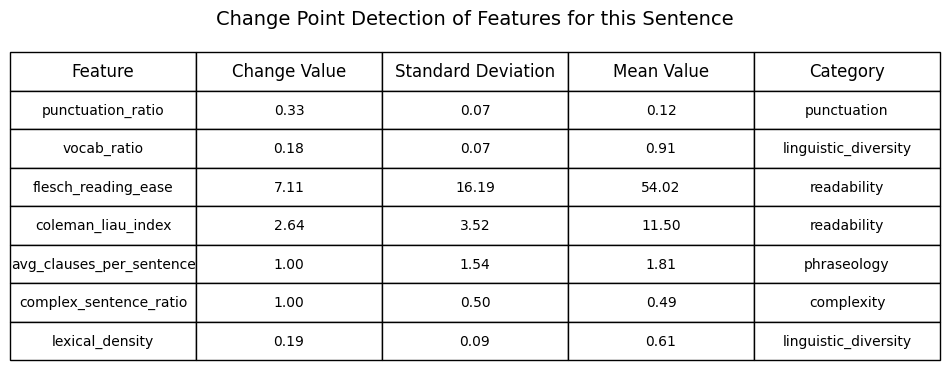

Change detected in sentence: Of course, no less disrespectful of the law is how Apollo Quiboloy broke it by refusing to surrender to the authorities, until recently, despite the arrest warrant served to him in his own kingdom.
Feature changes:


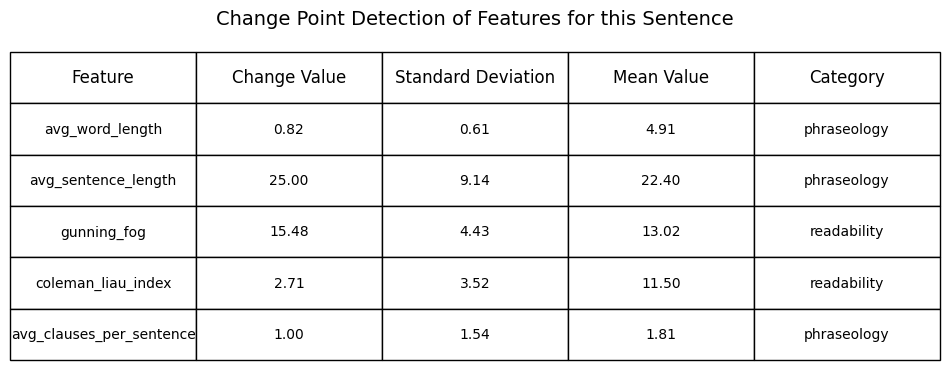

Change detected in sentence: Unfortunately, disrespect of the law, rather than the rule of law, has a long history in the Philippines.
Feature changes:


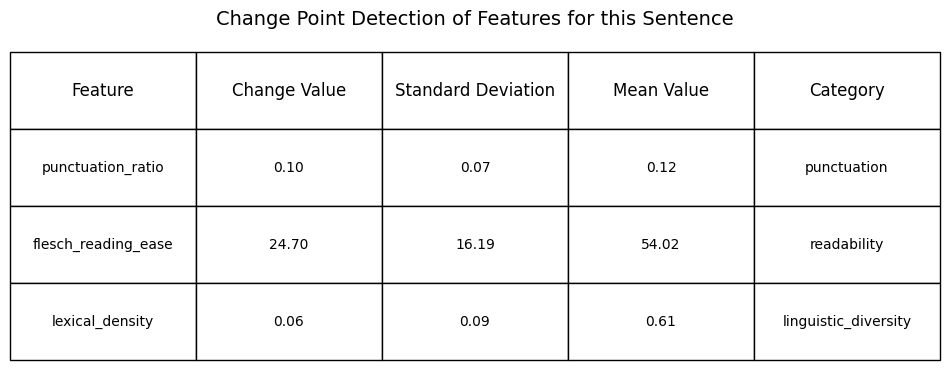

Change detected in sentence: The American expatriate businessman Harry Stonehill broke the law when he bribed high-level government officials in the early 1960s.
Feature changes:


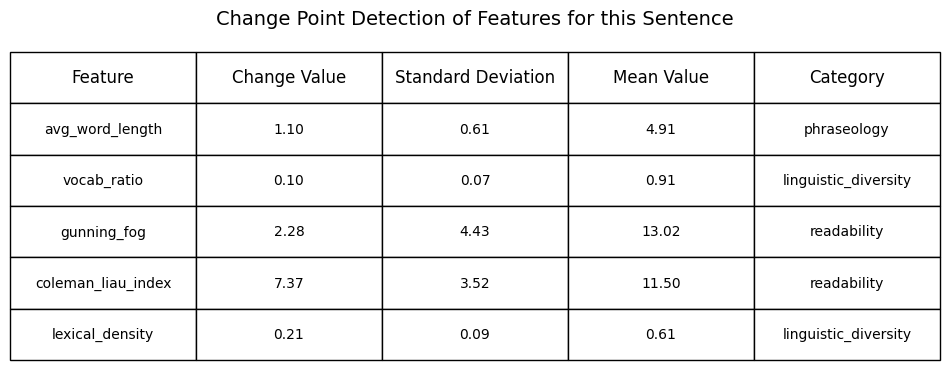

Change detected in sentence: Then Justice Secretary Jose W. Diokno caused the raid of the offices of 42 of Stonehill’s business establishments in 1962 and the arrest of Stonehill and some of his associates.
Feature changes:


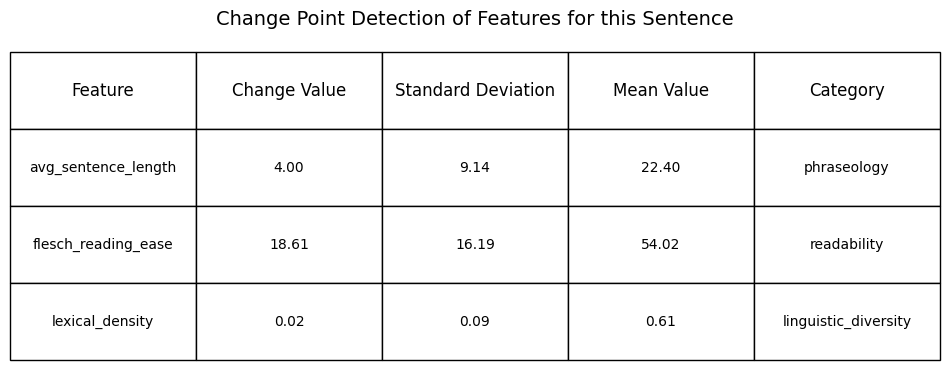

Change detected in sentence: Based on what was described as six army trucks worth of incriminating evidence, Stonehill was accused of tax evasion, economic sabotage, and various other charges that could have been established by his Blue Book which mysteriously went missing.
Feature changes:


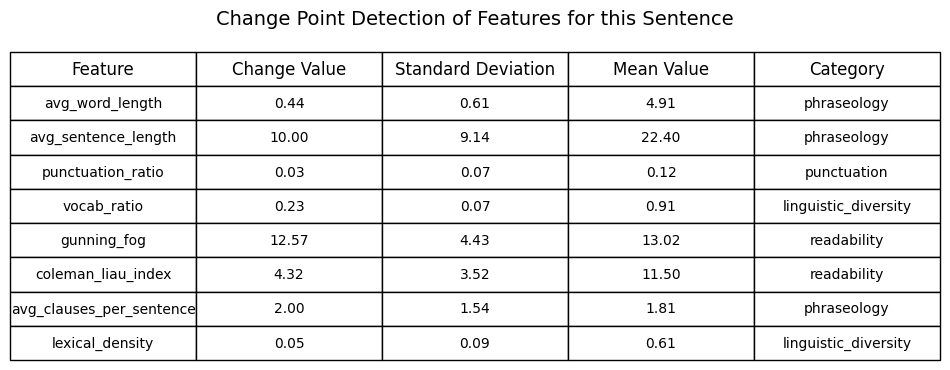

Change detected in sentence: If she is indeed non-Filipino and therefore disqualified, she violated our electoral law when she ran and took her oath of office as mayor of Bamban, Tarlac.
Feature changes:


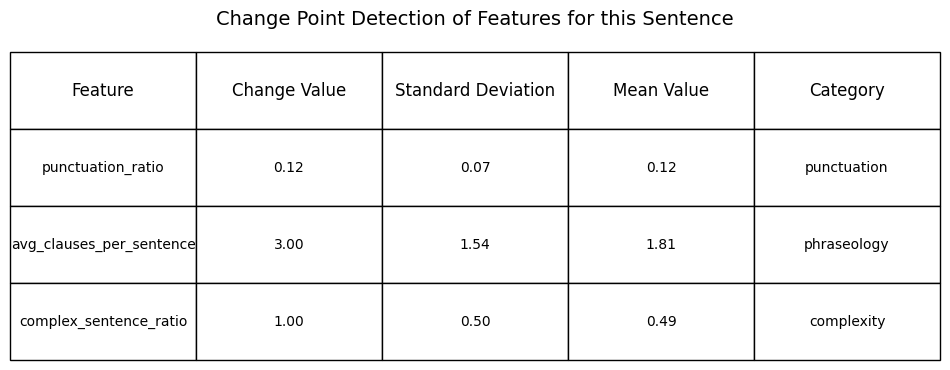

Change detected in sentence: It was impossible because her tax returns and SALN could only support a modest lifestyle.
Feature changes:


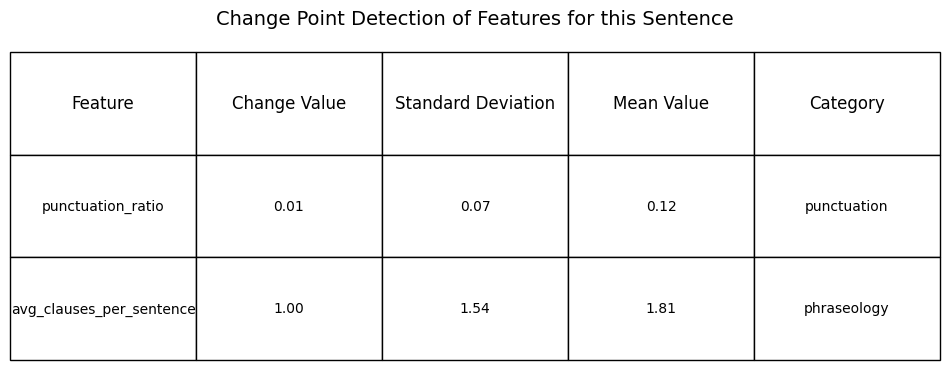

Change detected in sentence: As Reuters reported, even as Philippine authorities had filed several counts of money laundering, Guo continues to insist “she is natural-born Philippine citizen facing ‘malicious accusations,’ and had no knowledge of criminality.” This is strange because she could not even remember her roots, even her playmates while growing up.
Feature changes:


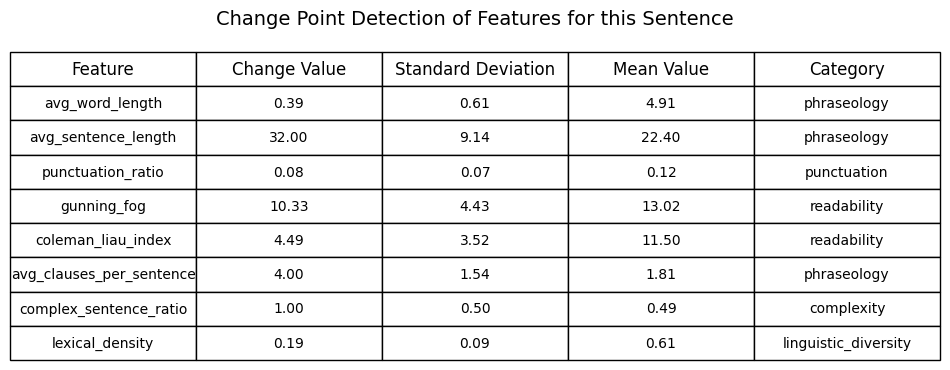

Change detected in sentence: For weeks before she escaped from the Philippines to Malaysia, Singapore and Indonesia, our elected senators could not get through her.
Feature changes:


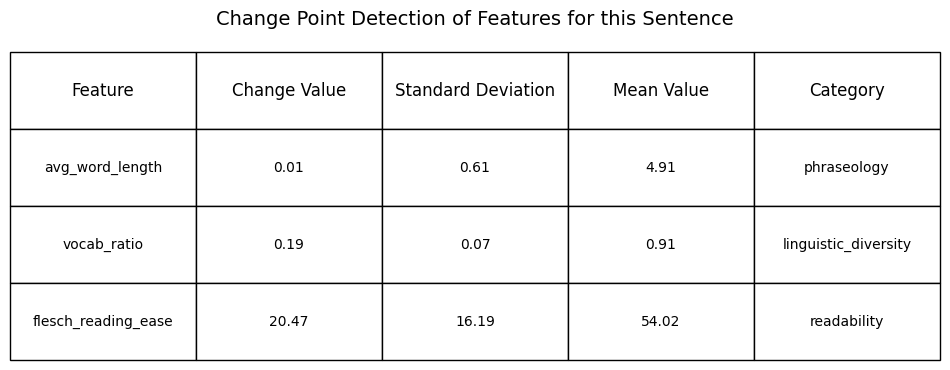

Change detected in sentence: It was a blank wall for them when Guo would always retort that she grew up in a farm, her only close friends were the farmhands in their piggery, or when confronted by documentary evidence of her true nationality, that she could not remember anymore.
Feature changes:


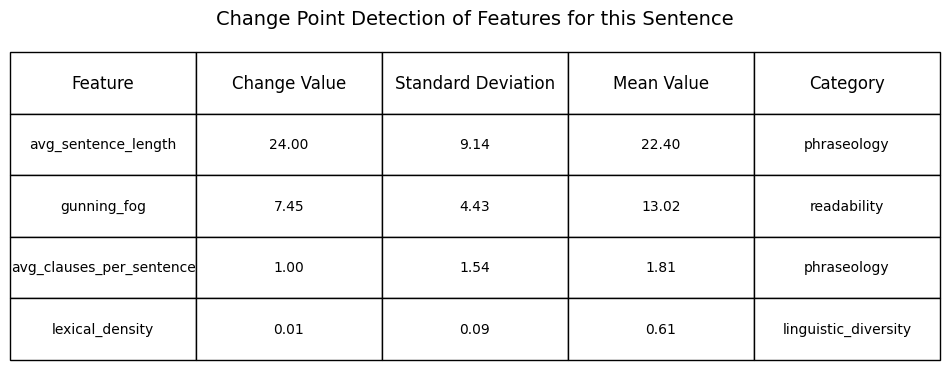

Change detected in sentence: The bigger picture is the undeniable involvement of those in authority.
Feature changes:


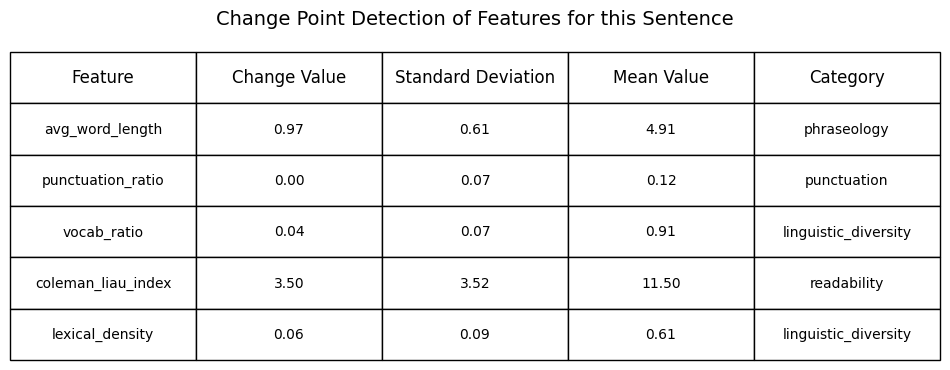

Change detected in sentence: As Rappler reported, a lawyer “committed lapses when he notarized the counter-affidavit of suspended Bamban Mayor Alice Guo in relation to a DOJ human trafficking complaint on Aug. 14.” By that time, Guo was already out of the country.
Feature changes:


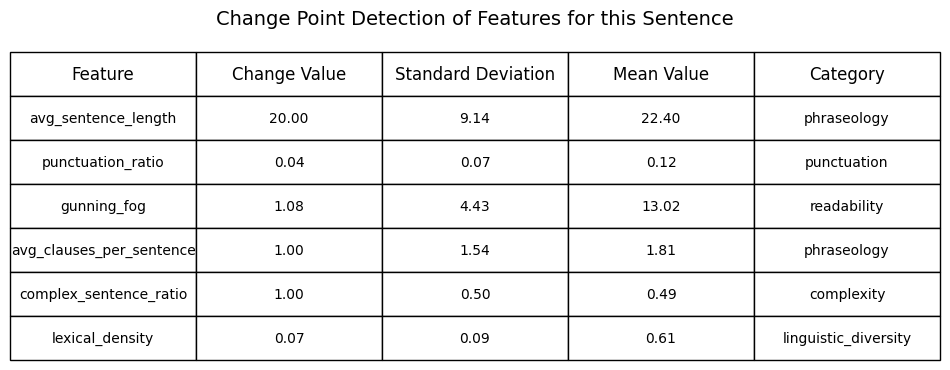

Change detected in sentence: Rommel Marbil who served the Senate arrest warrant to Guo.
Feature changes:


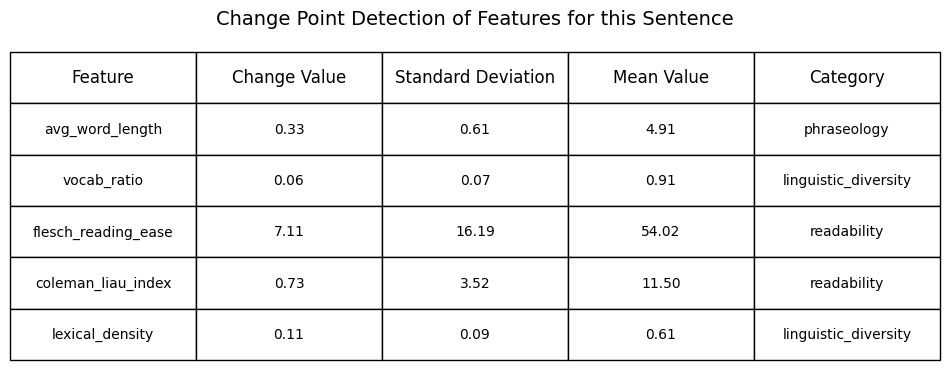

Change detected in sentence: She was brought back to Manila in yes, a private plane.
Feature changes:


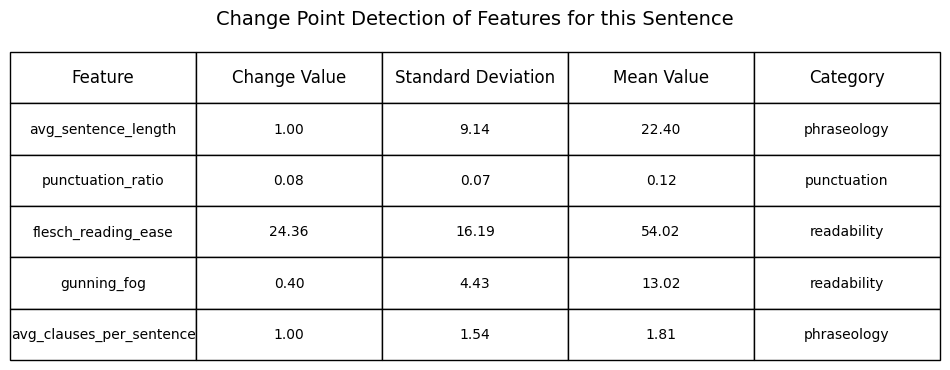

Change detected in sentence: There was little progress during the Senate hearing, notwithstanding the competent leadership of Senator Risa Hontiveros.
Feature changes:


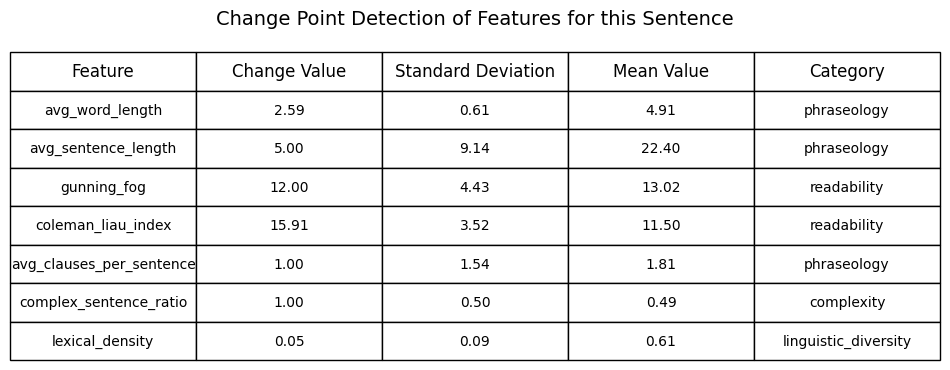

Change detected in sentence: We ourselves have nurtured such a habit of setting aside the law and just treating it as an elephant in the room, and in many cases, too, as a doormat.
Feature changes:


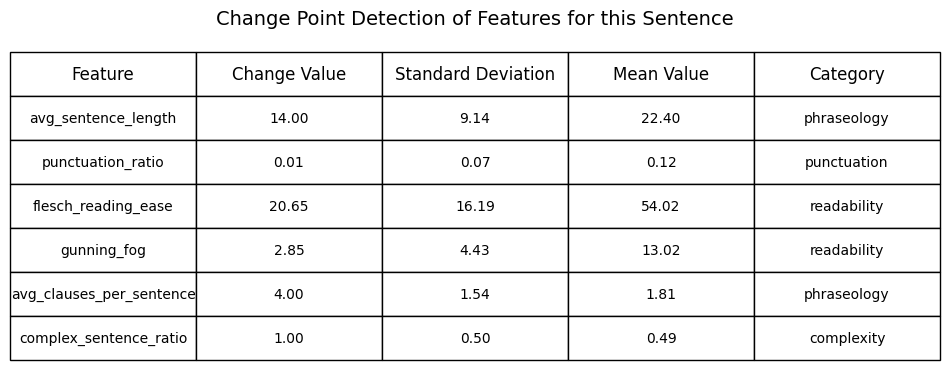

Change detected in sentence: This is in contrast to what the Philippines aspired for a “people-centered, clean and efficient governance” in the Philippine Development Plan 2017-2022.
Feature changes:


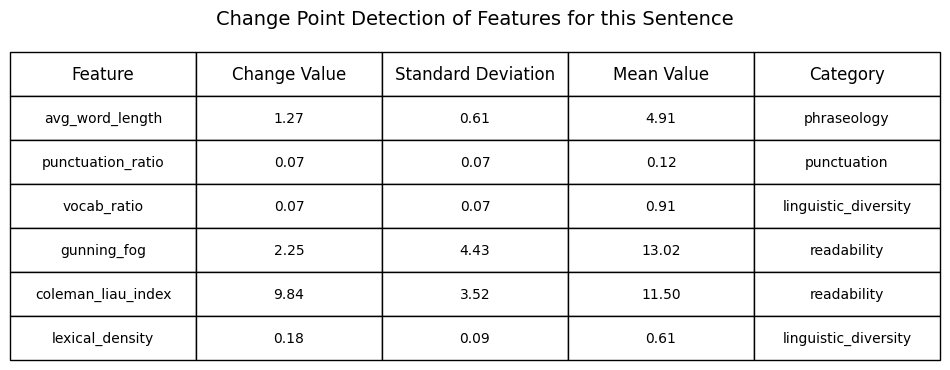

Change detected in sentence: In Chapter 5, we as a people, expressed our adherence to a high-trust society where “citizens obey the law, they willingly pay the correct taxes trusting that government will prudently manage the fiscal resources.” 

Indeed, the cornerstone of a high-trust society is the trust in government.
Feature changes:


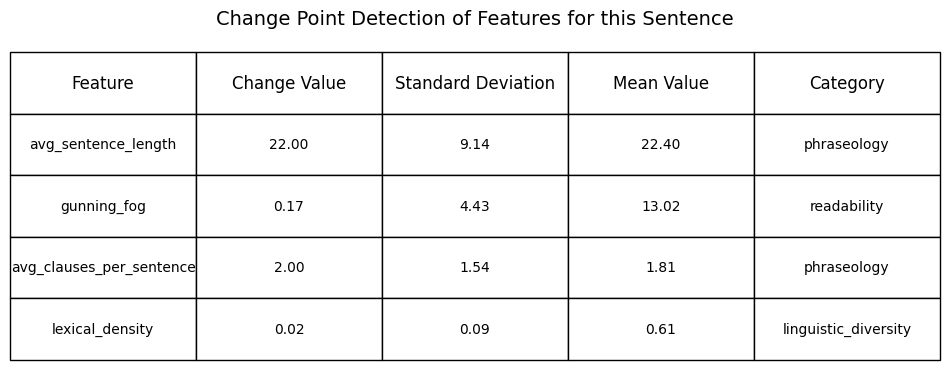

Change detected in sentence: But we have doubt whether the plan to “enhance the social fabric by making government worthy of people’s trust” actually bore fruit given Alice’s tale in POGO land.
Feature changes:


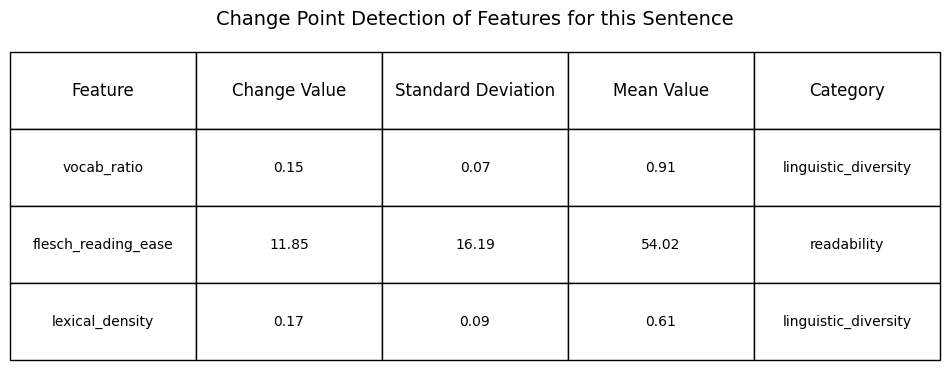


--- Percentage of Change by Category ---
Phraseology: 72.09% change detected out of 43 sentences.
Punctuation: 25.58% change detected out of 43 sentences.
Linguistic_diversity: 51.16% change detected out of 43 sentences.
Readability: 65.12% change detected out of 43 sentences.
Complexity: 13.95% change detected out of 43 sentences.


In [117]:
new_text = """Disrespecting the law is no less than an act of insolence, and in the “Law Insider” formulation, that is arrogant, presumptuous, impudent, or in fact even insulting. It could even be at once rude because it is no less than the Philippine law that is being crushed. 

What Alice Guo did was a shameless disregard of the law, call it contempt of the law. If true, being non-Filipino made it worse, many times over. Of course, no less disrespectful of the law is how Apollo Quiboloy broke it by refusing to surrender to the authorities, until recently, despite the arrest warrant served to him in his own kingdom. 

Unfortunately, disrespect of the law, rather than the rule of law, has a long history in the Philippines.

The American expatriate businessman Harry Stonehill broke the law when he bribed high-level government officials in the early 1960s. His case also dragged at least three former presidents in order to protect his $50 million business in tobacco and various commercial crops, among others. Then Justice Secretary Jose W. Diokno caused the raid of the offices of 42 of Stonehill’s business establishments in 1962 and the arrest of Stonehill and some of his associates. 

Based on what was described as six army trucks worth of incriminating evidence, Stonehill was accused of tax evasion, economic sabotage, and various other charges that could have been established by his Blue Book which mysteriously went missing. It contained the names of Filipino politicians and government officials who were alleged to have received bribe money from the American businessman. Before the case could be tried in court, Stonehill was subsequently deported by Malacañang.

Alice Guo treated Philippine law like rag when all evidence points to her faking her birth circumstances to gain entry into the Philippines and become a Filipino citizen. If she is indeed non-Filipino and therefore disqualified, she violated our electoral law when she ran and took her oath of office as mayor of Bamban, Tarlac. This gains credence in the face of Guo’s fingerprints being a perfect match with a Chinese national, Guo Hua Ping. Guo could not explain how she was able to construct the multibillion building complex of POGO business in Tarlac. It was impossible because her tax returns and SALN could only support a modest lifestyle.

As Reuters reported, even as Philippine authorities had filed several counts of money laundering, Guo continues to insist “she is natural-born Philippine citizen facing ‘malicious accusations,’ and had no knowledge of criminality.” This is strange because she could not even remember her roots, even her playmates while growing up.

For weeks before she escaped from the Philippines to Malaysia, Singapore and Indonesia, our elected senators could not get through her. It was a blank wall for them when Guo would always retort that she grew up in a farm, her only close friends were the farmhands in their piggery, or when confronted by documentary evidence of her true nationality, that she could not remember anymore. 

The bigger picture is the undeniable involvement of those in authority. 

She could not have entered the Philippines without the complicity of our immigration authorities. She could not have produced her Filipino birth certificate without the knowledge of the civil registrar and the statistics authorities. She could not have run for public office if our election authorities conducted a simple due diligence. She could not have sustained her POGO and alleged illegal activities if law enforcers did not turn a blind eye. She could not have escaped from the Philippines in July without official intervention. 

It's a sad commentary that even notarization of public documents could be dragged into this scandal. As Rappler reported, a lawyer “committed lapses when he notarized the counter-affidavit of suspended Bamban Mayor Alice Guo in relation to a DOJ human trafficking complaint on Aug. 14.” By that time, Guo was already out of the country. 

When she was finally arrested by Indonesian Interpol in Tangerang, it was disclosed that a Singaporean national helped Guo book four hotel rooms in Batam island. And to the surprise of many, no less than Interior Secretary Benhur Abalos and PNP Chief PGen. Rommel Marbil who served the Senate arrest warrant to Guo. She was brought back to Manila in yes, a private plane. 

There was little progress during the Senate hearing, notwithstanding the competent leadership of Senator Risa Hontiveros. All that Guo had to do to frustrate the senators’ spirited questioning was to claim innocence, short memory or the risk of incriminating herself. 

If at all, Guo even taught the Senate what to do and this was to convert the public hearing into an executive session. Only then could she disclose to the Senate who engineered her escape. When the Senate refused, Guo was persuaded to write on a piece of paper the name of the person who helped her escape. By the disclosure of two senators, another non-Filipino disregarded the Senate arrest warrant by helping Guo and her siblings and associates avoid arrest through the southern backdoor. 

Nothing should surprise us anymore when non-Filipinos have the gall to disrespect our legal and justice system. We ourselves have nurtured such a habit of setting aside the law and just treating it as an elephant in the room, and in many cases, too, as a doormat.

This is in contrast to what the Philippines aspired for a “people-centered, clean and efficient governance” in the Philippine Development Plan 2017-2022. In Chapter 5, we as a people, expressed our adherence to a high-trust society where “citizens obey the law, they willingly pay the correct taxes trusting that government will prudently manage the fiscal resources.” 

Indeed, the cornerstone of a high-trust society is the trust in government. 

But we have doubt whether the plan to “enhance the social fabric by making government worthy of people’s trust” actually bore fruit given Alice’s tale in POGO land."""
author = "Diwa C. Guinigundo"
thresholds = [0.5, 5, 0.02, 0.05, 5, 2, 1, 2]
# predicted_author = classify_new_text(new_text, clf)

# print(f"The predicted author is: {predicted_author}")
changepoints, explanations = detect_change_points_in_text(new_text, author, clf)